In [1]:
import numpy as np
from scipy.linalg import eig, svd
import deeptime as dt
from deeptime.numeric import is_sorted, spd_inv_sqrt, schatten_norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyemma.msm import MSM
from copy import deepcopy

from matplotlib import pyplot as plt
import numpy as np

from deeptime.clustering import BoxDiscretization
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.data import prinz_potential
from sklearn.model_selection import ShuffleSplit
import seaborn as sns


In [2]:

def gmrq(train_msm, test_dtraj, dim, r, lag): 
    
    # find  common states
    test_cm = TransitionCountEstimator(lagtime=lag, count_mode='sliding').fit_fetch(test_dtraj)
    common_symbols = set(train_msm.count_model.state_symbols).intersection(test_cm.state_symbols)
    common_states = train_msm.count_model.symbols_to_states(common_symbols)

    # derive test count matrix and MSM on common states 
    c0t_test = np.zeros((train_msm.n_states, train_msm.n_states), dtype=train_msm.transition_matrix.dtype)
    common_states_cm = test_cm.symbols_to_states(common_symbols)
    c0t_test[np.ix_(common_states, common_states)] = test_cm.count_matrix[np.ix_(common_states_cm, common_states_cm)]
    test_msm = MaximumLikelihoodMSM(lagtime=lag).fit_from_counts(c0t_test).fetch_model()
    
    assert np.allclose(train_msm.eigenvalues(k=dim), np.sort(train_msm.eigenvalues(k=dim))[::-1])
    
    # Calculate score
    # https://github.com/msmbuilder/msmbuilder/blob/515fd5c27836c797692d600216b5eb224dfc1c5d/msmbuilder/msm/msm.py
    V = train_msm.eigenvectors_right(k=dim)
    S = np.diag(test_msm.stationary_distribution)
    C = S.dot(test_msm.transition_matrix)
    
    R = (V.T.dot(C.dot(V)).dot(np.linalg.inv(V.T.dot(S.dot(V)))))**r
    result = np.trace(R)
    
    return result

def discretize(train_data, n_clusters, test_data=None): 
        # Discretize
    try:
        v0, v1 = np.concatenate(train_data).min(), np.concatenate(train_data).max()
        cmod = BoxDiscretization(dim=1, n_boxes=n_clusters, 
                                    v0=[v0], v1=[v1])
        
        cluster = cmod.fit_fetch(np.concatenate(train_data))
        train_dtraj = [cluster.transform(x) for x in train_data]
    except Exception as e: 
        print(v0, v1, n_clusters)
        print(e)
        
    if test_data is not None:
        test_dtraj = [cluster.transform(x) for x in test_data]    
    else: 
        test_dtraj = None
        
    return train_dtraj, test_dtraj
    
    
def score(train_dtraj, test_dtraj=None, dim=2, r=2, method='vamp',lag=2):
    mod = MaximumLikelihoodMSM(lagtime=lag).fit_fetch(train_dtraj)
    
    use_cv = test_dtraj is not None
    
    if not use_cv: 
        test_dtraj = deepcopy(train_dtraj)
    try: 
        if method.lower() =='vamp': 
            result = mod.score(test_dtraj, dim=dim, r=r)
        elif method.lower() == 'gmrq': 
            result = gmrq(mod, test_dtraj, dim=dim, r=r, lag=lag)
        elif method.lower() == 'eigenvalues': 
            assert not use_cv, "can't use eigenvalues with CV method"
            result = np.sum(mod.eigenvalues(k=dim)**r)
    except: 
        result = np.nan
        
    return result
    
    
def score_cv(data, cv_splitter, n_clusters, dim=2, r=2, method='vamp',lag=2): 
    results = []
    for train_ix, test_ix in cv_splitter.split(data): 
        test_data, train_data = data[test_ix], data[train_ix]
        
        train_dtraj, test_dtraj = discretize(train_data=train_data, 
                                             test_data=test_data, 
                                             n_clusters=n_clusters)
        
        # Score
        result = score(train_dtraj, test_dtraj, dim=dim, r=r, method=method, lag=lag)
        results.append(result)
        
    return np.array(results)

def score_bootstrap(data, rng, n_iterations, n_clusters, dim=2, r=2, method='vamp', lag=2): 
    results = []
    
    ix = np.arange(len(data))
    for i in range(n_iterations):
        new_ix = rng.choice(ix, size=ix.shape[0], replace=True)
        train_data = [data[j] for j in new_ix]
        train_dtraj, _ = discretize(train_data=train_data, 
                                    test_data=None, 
                                    n_clusters=n_clusters)
        result = score(train_dtraj, dim=dim, r=r, method=method, lag=lag)
        results.append(result)
        
    return np.array(results)


def timescale_bootstrap(data, rng, n_iterations, n_clusters, dim, lag):
    results = []
    
    ix = np.arange(len(data))
    for i in range(n_iterations):
        new_ix = rng.choice(ix, size=ix.shape[0], replace=True)
        train_data = [data[j] for j in new_ix]
        train_dtraj, _ = discretize(train_data=train_data, 
                                    test_data=None, 
                                    n_clusters=n_clusters)
        mod = MaximumLikelihoodMSM(lagtime=lag).fit_fetch(train_dtraj)
        result = np.array([np.nan]*(dim-1))
        for j, ts in enumerate(mod.timescales(dim-1)): 
            result[j] = ts
        
        results.append(result)

    return np.array(results)    

def vamp(mod,  dim: int = 2, epsilon: float = 1e-15) -> float: 

    cmat = mod.count_model.count_matrix
    tmat = mod.transition_matrix
    pi = mod.stationary_distribution
    
    # VAMP scores
    # Empirical covariances
    cov0t = cmat
    cov00 = np.diag(cov0t.sum(axis=1))
    covtt = np.diag(cov0t.sum(axis=0))
    
    # Symmetrized tmat
    # reweight operator to empirical distribution
    C0t_re = cov00 @ tmat
    # symmetrized operator and SVD
    tmat_sym = np.linalg.multi_dot([spd_inv_sqrt(cov00, epsilon=epsilon, method='QR'), C0t_re,
                                 spd_inv_sqrt(covtt, epsilon=epsilon, method='QR')])

    # SVD
    U, singular_values, Vt = svd(tmat_sym, compute_uv=True)
    U = spd_inv_sqrt(cov00, epsilon=epsilon) @ U
    Vt = Vt @ spd_inv_sqrt(covtt, epsilon=epsilon)
    V = Vt.T
    
    
    # Sort by singular values
    sort_ix = np.argsort(singular_values)[::-1][:dim]  # indices to sort in descending order
    U = U[:, sort_ix]
    V = V[:, sort_ix]
    singular_values = singular_values[sort_ix]
    
    A = np.atleast_2d(spd_inv_sqrt(U.T.dot(cov00).dot(U), epsilon=epsilon))
    B = np.atleast_2d(U.T.dot(cov0t).dot(V))
    C = np.atleast_2d(spd_inv_sqrt(V.T.dot(covtt).dot(V), epsilon=epsilon))
    ABC = np.linalg.multi_dot([A, B, C])
    vamp1 = schatten_norm(ABC, 1) ** 1
    vamp2 = schatten_norm(ABC, 2) ** 2
    
    # GMRQ like scores
    
    
    return vamp2, (mod.eigenvalues(2)**2).sum(), mod.timescales(1)[0]



def mod_from_c0t(C0t):
    cmod = dt.markov.TransitionCountModel(count_matrix=C0t)
    est = dt.markov.msm.MaximumLikelihoodMSM(lagtime=1, reversible=True)
    est.fit_from_counts(cmod)
    msm = est.fetch_model()  
    return msm, schatten_norm(C0t.T - C0t, 2) ** 2, None


In [3]:
T = np.array([[0.5, 0.34, 0.16], [0.28, 0.5, 0.22], [0.15, 0.25,0.6 ]])
N_obs = 20
N_trajs = 10000
mod = MSM(T)

dtrajs = [mod.simulate(N=N_obs) for _ in range(N_trajs)]
cmats = [dt.markov.TransitionCountEstimator(lagtime=1, count_mode='sliding').fit_fetch(dtraj).count_matrix 
        for dtraj in dtrajs]
cmat_ref = N_obs*np.diag(mod.stationary_distribution) @ T

In [4]:
lag = 1
vamps = []
gmrqs = []
evs = []
ts = []
errs = []
deltas = []
iteration = []
masks = []
totals = []
for i in range(1, 1000): #, len(cmats)):
    _, err, _ = mod_from_c0t(cmats[i])
    
    vamp = score(dtrajs[i], test_dtraj=None, dim=2, r=2, method='vamp',lag=1)
    gmrq_score = score(dtrajs[i], test_dtraj=None, dim=2, r=2, method='gmrq',lag=1)
    ev = score(dtrajs[i], test_dtraj=None, dim=2, r=2, method='eigenvalues',lag=1)
    try:
        mod = MaximumLikelihoodMSM(lagtime=lag).fit_fetch(dtrajs[i])
        t = mod.timescales()[0]
    except: 
        t = np.nan
    
#     msm, err, _ = mod_from_c0t(cmats[i])
#     try:
#         score, ev, t = vamp(msm)

#     except: 
#         score = np.nan
#         ev = np.nan
#         t = np.nan
        
    vamps.append(vamp)
    gmrqs.append(gmrq_score)
    
    evs.append(ev)
    ts.append(t)
    errs.append(err)
    iteration.append(i)
df = pd.DataFrame(dict(vamp2 = vamps, gmrq=gmrqs,  evs = evs, timescales=ts, err=errs, 
                       iteration=iteration))

Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [2] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [2] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [2] due to error in estimation: Some row and corresponding column of the count matrix C have zero c

In [12]:
df['rank'] = df['vamp2'].rank(ascending=False)
df.sort_values(by=['rank'], inplace=True)
# df.head()
offset = 10

bad_ix = []
for i, row1 in df.iterrows():
    ts = row1['timescales']
    rank = row1['rank']
    ix = row1['iteration']

    tmp = []
    max_rank = int(df['rank'].max())
    print(rank, end=', ')

    while rank <= max_rank: 
        
        new_rank = df['rank'].values[np.argmin(np.abs(df['rank']-int(rank)))]
        row2 = df.loc[df['rank']==new_rank, :]

        if row2['timescales'].values[0] > ts: 
            tmp.append(row2['iteration'].values[0])
            
            ts = row2['timescales'].values[0]

        rank = new_rank + offset
        
#         print(rank, end=' ')
        
    if len(tmp)>0: 
        tmp.append(ix)
        tmp = [tmp[-1]] + tmp[:-1]
        bad_ix.append(tuple(tmp))

1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.5, 13.5, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.5, 49.5, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.5, 59.5, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.5, 111.5, 113.0, 114.0, 115.5, 115.5, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.5, 130.5, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 15

In [13]:
def grad(x, df):
    result = df.loc[df.iteration==x[-1], "timescales"].values[0]-df.loc[df.iteration==x[0], 'timescales'].values[0]
    result /= df.loc[df.iteration==x[-1], "vamp2"].values[0]-df.loc[df.iteration==x[0], 'vamp2'].values[0]
    return result

def del_ts(x, df):
    return df.loc[df.iteration==x[-1], "timescales"].values[0]-df.loc[df.iteration==x[0], 'timescales'].values[0]

sort_ix = np.argsort([del_ts(x, df) for x in bad_ix])
bad_ix_sorted = [bad_ix[i] for i in sort_ix]

ix = df.iteration.isin(bad_ix_sorted[-1])

df.loc[ix, :]

,vamp2,gmrq,evs,timescales,err,iteration,rank
130,1.376596,1.185995,1.185995,1.189035,18.0,131,194.0
997,1.365300,1.381245,1.381245,2.074015,12.0,998,204.0
290,1.352819,1.424948,1.424948,2.337025,2.0,291,214.0


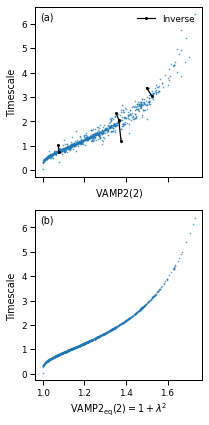

In [15]:
with sns.plotting_context('paper'):
    fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(3, 6))
    kws = dict(s=1, alpha=0.5, marker='o')
    axes[0].scatter(df['vamp2'], df['timescales'], **kws)

    for j in [-1, -50, -75]:
        ix = df.iteration.isin(bad_ix_sorted[j])
        if j == -1:
            label='Inverse'
        else: 
            label=None
            
        axes[0].plot(df.loc[ix, 'vamp2'], df.loc[ix, 'timescales'], color='k', label=label, 
                     marker='o', ms=2)

    axes[1].scatter(df['gmrq'], df['timescales'], **kws)
    
    axes[0].set_ylabel('Timescale')
    axes[1].set_ylabel('Timescale')
    axes[0].set_xlabel('VAMP2$(2)$',labelpad=10)
    axes[1].set_xlabel(r'VAMP2$_{\mathrm{eq}}(2) = 1+\lambda^2$')
    for i, ax in enumerate(axes.flatten()): 
        ax.annotate(text=['(a)', '(b)', '(c)'][i], xy=(0.03, 0.97), xycoords='axes fraction', ha='left',va='top')
    
    axes[0].legend(loc='upper right', frameon=False)
    plt.tight_layout()
    
    plt.savefig('timescale_vs_vamp_vs_evs.pdf', bbox_inches='tight')